# Employee Performance and Retention Analysis Project

This notebook covers all phases of analysis, predictive modeling, deep learning, and reporting for employee performance and retention data.

## Phase 1 - Data Collection and Exploratory Data Analysis (EDA)

In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode, f_oneway
%matplotlib inline

# Load dataset
employee_data = pd.read_csv('C:\\Tutedude_DS_Course\\Assignments\\Data\\employee_data.csv')
employee_data.head()

,EmployeeID,Name,Age,Department,Salary,YearsAtCompany,PerformanceScore,Attrition
0,1,John Doe,29,Sales,55000,3,80,No
1,2,Jane Smith,35,HR,60000,7,85,No
2,3,Michael Brown,40,Engineering,80000,10,95,Yes
3,4,Emily Davis,28,Marketing,65000,5,78,No
4,5,David Johnson,50,Sales,75000,20,88,Yes


In [198]:
# Data Cleaning
employee_data.drop_duplicates(inplace=True)
# Checking for missing values
employee_data.isnull().sum()

EmployeeID          0
Name                0
Age                 0
Department          0
Salary              0
YearsAtCompany      0
PerformanceScore    0
Attrition           0
dtype: int64

In [199]:
# Descriptive statistics for numerical columns
descriptive_stats = employee_data.describe().T
descriptive_stats['mode'] = employee_data.mode().iloc[0]
descriptive_stats['var'] = descriptive_stats['std']**2
descriptive_stats

,count,mean,std,min,25%,50%,75%,max,mode,var
EmployeeID,100.0,50.50,29.011492,1.0,25.75,50.5,75.25,100.0,1,8.416667e+02
Age,100.0,36.57,8.318478,25.0,29.75,35.0,41.25,60.0,29.0,6.919707e+01
Salary,100.0,72820.00,12643.823102,43000.0,65000.00,72000.0,82750.00,95000.0,68000.0,1.598663e+08
YearsAtCompany,100.0,10.80,6.361183,1.0,5.00,10.0,16.00,25.0,2.0,4.046465e+01
PerformanceScore,100.0,84.94,6.349771,70.0,80.00,85.5,90.00,95.0,80.0,4.031960e+01


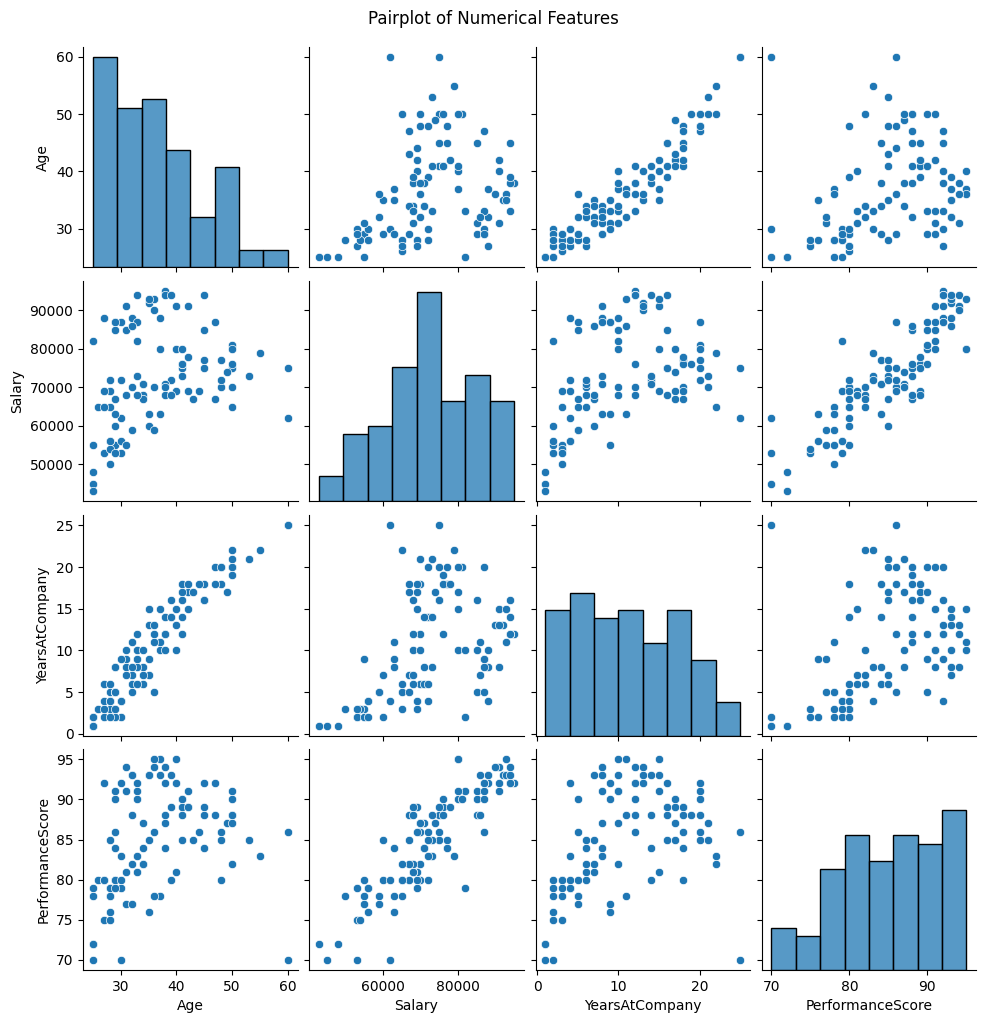

In [200]:
# Visualize pairplot
sns.pairplot(employee_data.select_dtypes(include=[np.number]).drop(columns=['EmployeeID']))
plt.suptitle('Pairplot of Numerical Features', y=1.02)
plt.show()

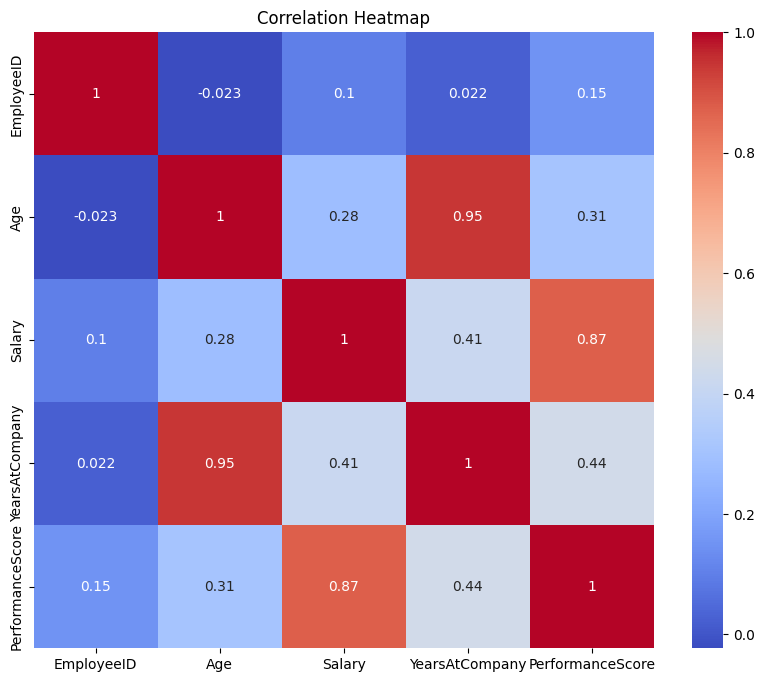

In [201]:
# Correlation Heatmap
plt.figure(figsize=(10,8))
corr = employee_data.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

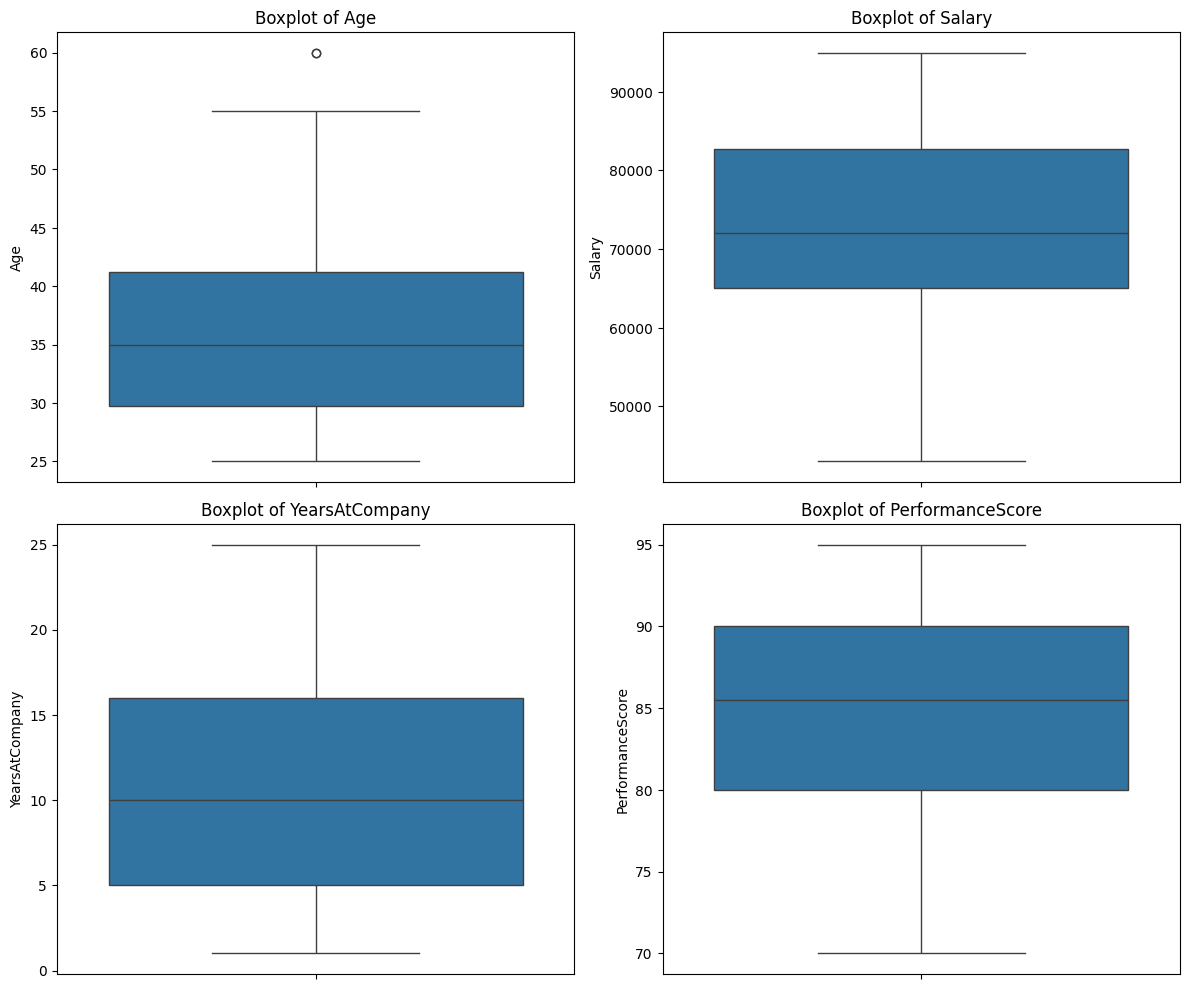

In [202]:
# Boxplots to identify outliers
plt.figure(figsize=(12,10))
num_cols = ['Age', 'Salary', 'YearsAtCompany', 'PerformanceScore']
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=employee_data[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

## Phase 1 - Step 3: Probability and Statistical Analysis

In [203]:
# Probability of attrition overall
prob_attrition = (employee_data['Attrition'] == 'Yes').mean()
prob_attrition

np.float64(0.39)

In [204]:
# Probability of attrition by department
attrition_dept = employee_data.groupby('Department')['Attrition'].apply(lambda x: (x == 'Yes').mean())
attrition_dept

Department
Engineering    0.428571
HR             0.346154
Marketing      0.200000
Sales          0.538462
Name: Attrition, dtype: float64

In [205]:
# Bayes Theorem - Probability of attrition given performance score category (High if > 85, else Low)
employee_data['PerformanceHigh'] = np.where(employee_data['PerformanceScore'] > 85, 'High', 'Low')

# P(Attrition|PerformanceHigh) = P(PerformanceHigh|Attrition)*P(Attrition)/P(PerformanceHigh)
p_attrition = prob_attrition
p_performance_high = (employee_data['PerformanceHigh'] == 'High').mean()
p_performance_high_given_attrition = employee_data[employee_data['Attrition'] == 'Yes']['PerformanceHigh'].value_counts(normalize=True).get('High', 0)
p_attrition_given_perf_high = (p_performance_high_given_attrition * p_attrition) / p_performance_high if p_performance_high>0 else np.nan
p_attrition_given_perf_high

np.float64(0.46)

In [206]:
# Hypothesis Testing - ANOVA for mean performance scores across departments
departments = employee_data['Department'].unique()
data_by_dept = [employee_data[employee_data['Department'] == dept]['PerformanceScore'] for dept in departments]
f_stat, p_value = f_oneway(*data_by_dept)
(f_stat, p_value)

(np.float64(25.781068086646336), np.float64(2.5591493445552065e-12))

## Phase 2 - Predictive Modeling

### Feature Engineering and Encoding

In [207]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

X = employee_data.drop(['EmployeeID', 'Name'], axis=1)
le = LabelEncoder()
X['Attrition'] = le.fit_transform(X['Attrition'])
X['Department'] = le.fit_transform(X['Department'])

# Scale numerical features
numerical_cols = ['Age', 'Salary', 'YearsAtCompany', 'PerformanceScore']
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

X.head()

,Age,Department,Salary,YearsAtCompany,PerformanceScore,Attrition,PerformanceHigh
0,-0.914607,3,-1.416484,-1.232364,-0.781900,0,Low
1,-0.189687,1,-1.019042,-0.600383,0.009497,0,Low
2,0.414412,0,0.570727,-0.126396,1.592290,1,High
3,-1.035427,2,-0.621600,-0.916373,-1.098459,0,Low
4,1.622612,3,0.173285,1.453558,0.484335,1,High


### Employee Attrition Prediction Model

In [208]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Target and features for attrition prediction
y = X['Attrition']
# Drop non-numeric columns from X_attrition
X_attrition = X.drop(['Attrition', 'PerformanceScore'], axis=1).select_dtypes(include=[np.number])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_attrition, y, test_size=0.2, random_state=42, stratify=y)

# Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predictions and evaluations
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

accuracy, precision, recall, f1


(0.75, 0.8, 0.5, 0.6153846153846154)

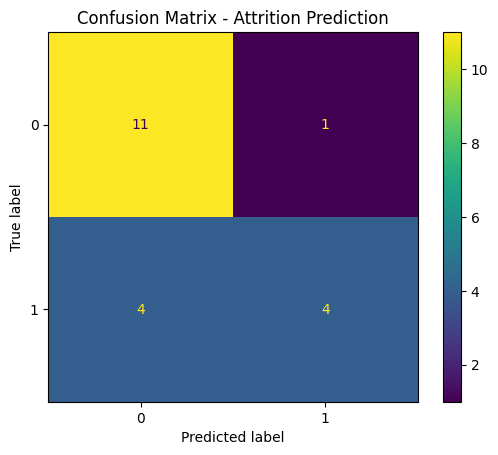

In [209]:
# Confusion Matrix visualization
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title('Confusion Matrix - Attrition Prediction')
plt.show()

### Employee Performance Prediction Model

In [210]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Target and features for performance prediction
y_perf = X['PerformanceScore']
# Drop non-numeric columns from X_performance
X_performance = X.drop(['Attrition', 'PerformanceScore'], axis=1).select_dtypes(include=[np.number])

# Split data
X_train_perf, X_test_perf, y_train_perf, y_test_perf = train_test_split(X_performance, y_perf, test_size=0.2, random_state=42)

# Linear Regression model
reg = LinearRegression()
reg.fit(X_train_perf, y_train_perf)

# Predict
y_pred_perf = reg.predict(X_test_perf)

# Metrics
mse = mean_squared_error(y_test_perf, y_pred_perf)
r2 = r2_score(y_test_perf, y_pred_perf)
(mse, r2)

(0.31791378392011216, 0.751469373982202)

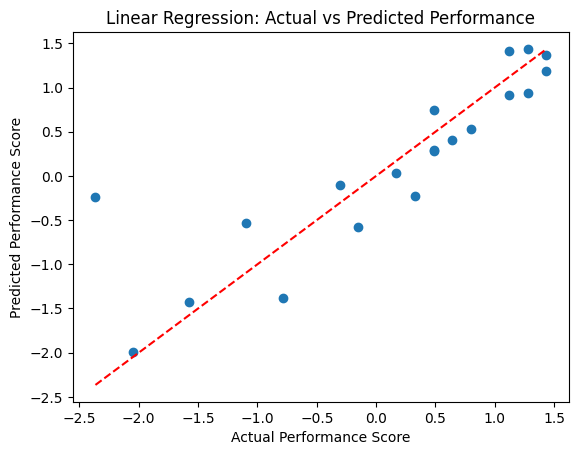

In [211]:
# Plot predicted vs actual
plt.scatter(y_test_perf, y_pred_perf)
plt.xlabel('Actual Performance Score')
plt.ylabel('Predicted Performance Score')
plt.title('Linear Regression: Actual vs Predicted Performance')
plt.plot([y_test_perf.min(), y_test_perf.max()], [y_test_perf.min(), y_test_perf.max()], 'r--')
plt.show()

## Phase 3 - Deep Learning Models

In [212]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input

# Neural Network model for performance prediction
model = Sequential([
    Input(shape=(input_dim,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Regression output
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train model
history = model.fit(X_train_perf, y_train_perf, epochs=50, validation_split=0.2, verbose=0)

# Evaluate on test data
test_loss, test_mae = model.evaluate(X_test_perf, y_test_perf, verbose=0)
(test_loss, test_mae)

(0.3412531614303589, 0.3897002041339874)

In [213]:
# Deep Learning for Employee Attrition Classification
# Prepare data
y_attrition = y.values  # binary labels
input_dim_class = X_attrition.shape[1]
from tensorflow.keras import Input

model_class = Sequential([
    Input(shape=(input_dim_class,)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Classification output
])

model_class.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history_class = model_class.fit(X_train, y_train, epochs=50, validation_split=0.2, verbose=0)

# Evaluate on test data
test_loss_class, test_acc_class = model_class.evaluate(X_test, y_test, verbose=0)
(test_loss_class, test_acc_class)

(0.6458860635757446, 0.75)

## Phase 4 - Reporting and Insights

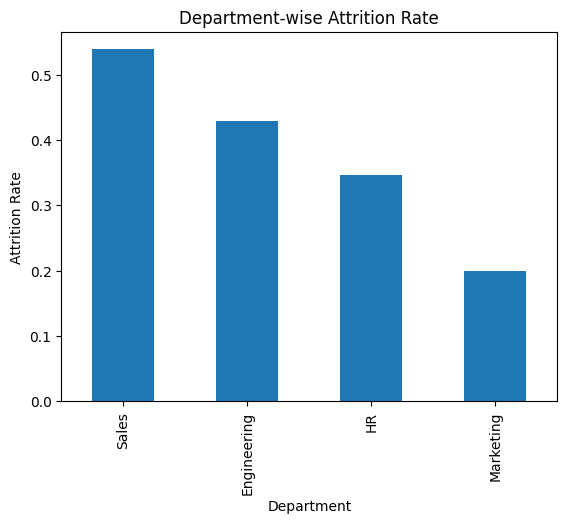

In [214]:
# Department-wise attrition rates
attrition_by_dept = employee_data.groupby('Department')['Attrition'].apply(lambda x: (x == 'Yes').mean()).sort_values(ascending=False)
attrition_by_dept.plot(kind='bar', title='Department-wise Attrition Rate')
plt.ylabel('Attrition Rate')
plt.show()

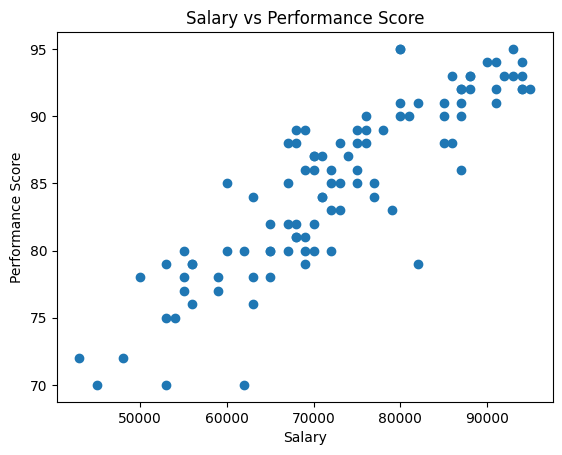

In [215]:
# Scatter plot - Salary vs. Performance Score
plt.scatter(employee_data['Salary'], employee_data['PerformanceScore'])
plt.xlabel('Salary')
plt.ylabel('Performance Score')
plt.title('Salary vs Performance Score')
plt.show()